# Text Embeddings with Sentence-Transformers

This notebook demonstrates state-of-the-art text embeddings using **Sentence-Transformers** - a Python library for generating high-quality BERT-based embeddings.

## Features:
- 🚀 **Fast local embeddings** (no API costs)
- 📊 **K-means clustering** with silhouette analysis
- 🎨 **t-SNE visualization** 
- 🔍 **Semantic similarity search**
- 💾 **Efficient storage** with compressed parquet

## Why Sentence-Transformers?
- ✅ **Free** - No API costs or AWS credentials needed
- ✅ **Fast** - ~1000 texts/minute on CPU
- ✅ **High Quality** - State-of-the-art BERT models
- ✅ **Flexible** - Multiple model options (384-768 dimensions)


In [33]:
# Setup and imports
import sys
import os
from pathlib import Path

# Add virtual environment
venv_path = '/home/ubuntu/dsan6000/dsan6000-final-project/.venv/lib/python3.12/site-packages'
if venv_path not in sys.path:
    sys.path.insert(0, venv_path)

# Core imports
import warnings
warnings.filterwarnings('ignore')

import json
import time
from datetime import datetime
from typing import List, Dict, Optional

# Data processing
import numpy as np
import pandas as pd

# Machine learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Progress tracking
from tqdm import tqdm

# Sentence Transformers - our embedding engine
from sentence_transformers import SentenceTransformer

# Setup paths
PROJECT_DIR = Path('/home/ubuntu/dsan6000/dsan6000-final-project')
DATA_RAW = PROJECT_DIR / "data" / "raw"
DATA_PROCESSED = PROJECT_DIR / "data" / "processed"

for path in [DATA_RAW, DATA_PROCESSED]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment ready")
print(f"📁 Data paths:")
print(f"   Raw: {DATA_RAW}")
print(f"   Processed: {DATA_PROCESSED}")


✅ Environment ready
📁 Data paths:
   Raw: /home/ubuntu/dsan6000/dsan6000-final-project/data/raw
   Processed: /home/ubuntu/dsan6000/dsan6000-final-project/data/processed


In [34]:
# Check and install required packages
import subprocess
import importlib

required = {
    'sentence-transformers': 'sentence-transformers',
    'pyarrow': 'pyarrow',  # For parquet files
    'plotly': 'plotly',
    'scikit-learn': 'sklearn',
    'tqdm': 'tqdm'
}

print("📦 Checking dependencies...")
missing = []
for package, import_name in required.items():
    try:
        importlib.import_module(import_name.replace('-', '_'))
        print(f"  ✅ {package}")
    except ImportError:
        missing.append(package)
        print(f"  ❌ {package} - missing")

if missing:
    print(f"\n💡 Install missing packages with:")
    print(f"   uv pip install {' '.join(missing)}")
else:
    print("\n✅ All dependencies installed!")


📦 Checking dependencies...
  ✅ sentence-transformers
  ✅ pyarrow
  ✅ plotly
  ✅ scikit-learn
  ✅ tqdm

✅ All dependencies installed!


## 1. Load Reddit Data


In [35]:
# Load sample Reddit data
submissions_file = DATA_RAW / "submissions-sample.json"

if submissions_file.exists():
    # Load real Reddit data
    with open(submissions_file, 'r') as f:
        submissions = [json.loads(line) for line in f]
    submissions_df = pd.DataFrame(submissions)
    
    # Combine title and selftext
    submissions_df['text'] = submissions_df['title'].fillna('') + ' ' + submissions_df['selftext'].fillna('')
    submissions_df['text'] = submissions_df['text'].str.strip()
    
    # Keep non-empty texts
    submissions_df = submissions_df[submissions_df['text'].str.len() > 10]
    
    print(f"✅ Loaded {len(submissions_df)} Reddit submissions")
else:
    # Create sample data for demo
    print("⚠️ Reddit data not found, creating sample data...")
    sample_texts = [
        "Rising rent prices in NYC are making it impossible to afford basic living expenses",
        "Tech layoffs are affecting job market stability across the country",
        "How to budget effectively when inflation keeps rising",
        "Housing crisis: Can't find affordable apartments anywhere near work",
        "Remote work opportunities are changing cost of living dynamics",
        "Grocery prices have doubled in my area over the past year",
        "Student loans and housing costs are crushing millennials",
        "Moving to a lower cost city saved me thousands annually",
        "The stock market volatility is impacting retirement savings",
        "Healthcare costs continue to rise faster than wages"
    ]
    
    submissions_df = pd.DataFrame({
        'text': sample_texts,
        'subreddit': ['personalfinance'] * len(sample_texts),
        'created_utc': pd.date_range('2023-01-01', periods=len(sample_texts), freq='D').astype(int) // 10**9
    })
    print(f"✅ Created {len(submissions_df)} sample texts")

# Display sample
print("\n📝 Sample texts:")
for i, text in enumerate(submissions_df['text'].head(3)):
    print(f"{i+1}. {text[:100]}...")


✅ Loaded 971 Reddit submissions

📝 Sample texts:
1. What if an app could manage your business for you and earn new streams of income? Would you like to ...
2. Just swiming and chillin...
3. Thursday night thread presented by NFL preseason week 4....


## 2. Sentence-Transformer Embeddings

### Available Models:
| Model | Dimensions | Speed | Quality | Use Case |
|-------|------------|-------|---------|----------|
| `all-MiniLM-L6-v2` | 384 | Fast | Good | General purpose (recommended) |
| `all-mpnet-base-v2` | 768 | Medium | Best | When quality matters most |
| `paraphrase-MiniLM-L6-v2` | 384 | Fast | Good | Semantic similarity |
| `all-MiniLM-L12-v2` | 384 | Fast | Better | Balanced option |


In [36]:
# Initialize Sentence Transformer
model_name = 'all-MiniLM-L6-v2'  # Fast and good quality

print(f"📥 Loading model: {model_name}")
print("   (First time will download ~80MB model)")

model = SentenceTransformer(model_name)
embedding_dim = model.get_sentence_embedding_dimension()

print(f"✅ Model loaded successfully!")
print(f"   Embedding dimensions: {embedding_dim}")
print(f"   Max sequence length: {model.max_seq_length}")


📥 Loading model: all-MiniLM-L6-v2
   (First time will download ~80MB model)
✅ Model loaded successfully!
   Embedding dimensions: 384
   Max sequence length: 256


In [37]:
# Generate embeddings
texts = submissions_df['text'].tolist()

# Limit for demo (remove for full dataset)
if len(texts) > 500:
    texts = texts[:500]
    submissions_df = submissions_df.head(500)
    print(f"⚠️ Limited to {len(texts)} texts for demo")

print(f"🚀 Generating embeddings for {len(texts)} texts...")
print("   This will take ~1 minute per 1000 texts on CPU")

# Generate embeddings with progress bar
embeddings = model.encode(
    texts,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\n✅ Embeddings generated!")
print(f"   Shape: {embeddings.shape}")
print(f"   Memory usage: {embeddings.nbytes / 1024**2:.1f} MB")

# Display statistics
print(f"\n📊 Embedding statistics:")
print(f"   Min: {embeddings.min():.4f}")
print(f"   Max: {embeddings.max():.4f}")
print(f"   Mean: {embeddings.mean():.4f}")
print(f"   Std: {embeddings.std():.4f}")


⚠️ Limited to 500 texts for demo
🚀 Generating embeddings for 500 texts...
   This will take ~1 minute per 1000 texts on CPU


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


✅ Embeddings generated!
   Shape: (500, 384)
   Memory usage: 0.7 MB

📊 Embedding statistics:
   Min: -0.2400
   Max: 0.2350
   Mean: 0.0002
   Std: 0.0510


## 3. K-means Clustering with Silhouette Analysis


In [38]:
# Standardize embeddings for better clustering
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

print(f"✅ Standardized embeddings")
print(f"   Mean: {embeddings_scaled.mean():.6f} (should be ~0)")
print(f"   Std: {embeddings_scaled.std():.6f} (should be ~1)")


✅ Standardized embeddings
   Mean: -0.000000 (should be ~0)
   Std: 1.000000 (should be ~1)


In [39]:
# Silhouette analysis to find optimal K
max_clusters = min(15, len(embeddings_scaled) // 10, len(embeddings_scaled) - 1)
K_range = range(2, min(max_clusters + 1, 12))

silhouette_scores = []
inertias = []

print("🔍 Performing Silhouette Analysis...")
print("-" * 50)

for k in K_range:
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings_scaled)
    
    # Calculate metrics
    if len(np.unique(labels)) > 1:  # Check if we have more than 1 cluster
        score = silhouette_score(embeddings_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)
    
    inertia = kmeans.inertia_
    inertias.append(inertia)
    
    print(f"K={k:2d}: Silhouette={silhouette_scores[-1]:.4f}, Inertia={inertia:.1f}")

# Find optimal K
if silhouette_scores:
    optimal_idx = np.argmax(silhouette_scores)
    optimal_k = list(K_range)[optimal_idx]
else:
    optimal_k = 2

print("-" * 50)
print(f"✅ Optimal K = {optimal_k} (silhouette = {silhouette_scores[optimal_idx]:.4f})")


🔍 Performing Silhouette Analysis...
--------------------------------------------------
K= 2: Silhouette=0.0115, Inertia=186655.6
K= 3: Silhouette=0.0159, Inertia=183126.7
K= 4: Silhouette=0.0177, Inertia=180802.4
K= 5: Silhouette=0.0203, Inertia=178521.5
K= 6: Silhouette=0.0201, Inertia=176962.9
K= 7: Silhouette=0.0197, Inertia=175614.3
K= 8: Silhouette=0.0198, Inertia=174551.1
K= 9: Silhouette=0.0225, Inertia=173332.0
K=10: Silhouette=0.0147, Inertia=172253.2
K=11: Silhouette=0.0217, Inertia=170865.3
--------------------------------------------------
✅ Optimal K = 9 (silhouette = 0.0225)


In [40]:
# Visualize clustering metrics
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Silhouette Score vs K', 'Elbow Curve'),
    horizontal_spacing=0.15
)

# Silhouette scores
fig.add_trace(
    go.Scatter(x=list(K_range), y=silhouette_scores, 
               mode='lines+markers', name='Silhouette',
               line=dict(color='blue', width=2),
               marker=dict(size=8)),
    row=1, col=1
)

# Mark optimal K
fig.add_trace(
    go.Scatter(x=[optimal_k], y=[silhouette_scores[optimal_idx]],
               mode='markers', name=f'Optimal K={optimal_k}',
               marker=dict(size=12, color='red', symbol='star')),
    row=1, col=1
)

# Elbow curve (inertia)
fig.add_trace(
    go.Scatter(x=list(K_range), y=inertias,
               mode='lines+markers', name='Inertia',
               line=dict(color='green', width=2),
               marker=dict(size=8)),
    row=1, col=2
)

fig.update_xaxes(title_text="Number of Clusters (K)", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters (K)", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=1)
fig.update_yaxes(title_text="Inertia", row=1, col=2)

fig.update_layout(
    height=400,
    title_text="Clustering Metrics Analysis",
    showlegend=True,
    template='plotly_white'
)

fig.show()


## 4. Final Clustering & t-SNE Visualization


In [41]:
# Perform final clustering with optimal K
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(embeddings_scaled)

# Add to dataframe
submissions_df['cluster'] = cluster_labels

# Cluster statistics
print("📊 Cluster Statistics:")
print("-" * 50)

cluster_stats = submissions_df.groupby('cluster').agg({
    'text': 'count'
}).rename(columns={'text': 'count'})

# Add percentage
cluster_stats['percentage'] = (cluster_stats['count'] / len(submissions_df) * 100).round(1)

print(cluster_stats)

# Sample texts from each cluster
print("\n📝 Sample Texts per Cluster:")
print("=" * 80)
for cluster in range(optimal_k):
    cluster_df = submissions_df[submissions_df['cluster'] == cluster]
    print(f"\n🔹 Cluster {cluster} ({len(cluster_df)} texts, {len(cluster_df)/len(submissions_df)*100:.1f}%):")
    for i, text in enumerate(cluster_df['text'].head(2), 1):
        print(f"  {i}. {text[:150]}...")
    print()


📊 Cluster Statistics:
--------------------------------------------------
         count  percentage
cluster                   
0           47         9.4
1           87        17.4
2           41         8.2
3           96        19.2
4           40         8.0
5           58        11.6
6           54        10.8
7           37         7.4
8           40         8.0

📝 Sample Texts per Cluster:

🔹 Cluster 0 (47 texts, 9.4%):
  1. [REQUEST] Literature into Film: Theory And Practical Approaches by Linda Costanzo Cahir...
  2. 21:00 Yukon Men: Roughing It (Animal Planet)...


🔹 Cluster 1 (87 texts, 17.4%):
  1. And Here. We. Go. [removed]...
  2. [QC] This Gucci Bee Cardigan [deleted]...


🔹 Cluster 2 (41 texts, 8.2%):
  1. [ps4] [H] animus, 4 nitro, 4 turbo, 1 ODC [W] 2k or offers! [deleted]...
  2. [H] Gut Knife | Vanilla [W] 25k I have a Gut Knife | Vanilla, looking for b/o 25 keys.

https://s.metjm.net/2T2FChW.jpg

Send offers here: https://ste...


🔹 Cluster 3 (96 texts, 19.2%):
  1

In [42]:
# t-SNE visualization for 2D projection
print("🔄 Computing t-SNE (this may take a moment)...")

# Use PCA first if high dimensional
if embeddings_scaled.shape[1] > 50:
    pca = PCA(n_components=50)
    embeddings_pca = pca.fit_transform(embeddings_scaled)
    print(f"   PCA reduced: {embeddings_scaled.shape[1]} → 50 dimensions")
else:
    embeddings_pca = embeddings_scaled

# t-SNE with appropriate perplexity
perplexity = min(30, len(embeddings_pca) // 4)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Add to dataframe
submissions_df['tsne_x'] = embeddings_2d[:, 0]
submissions_df['tsne_y'] = embeddings_2d[:, 1]

print("✅ t-SNE complete!")


🔄 Computing t-SNE (this may take a moment)...
   PCA reduced: 384 → 50 dimensions
✅ t-SNE complete!


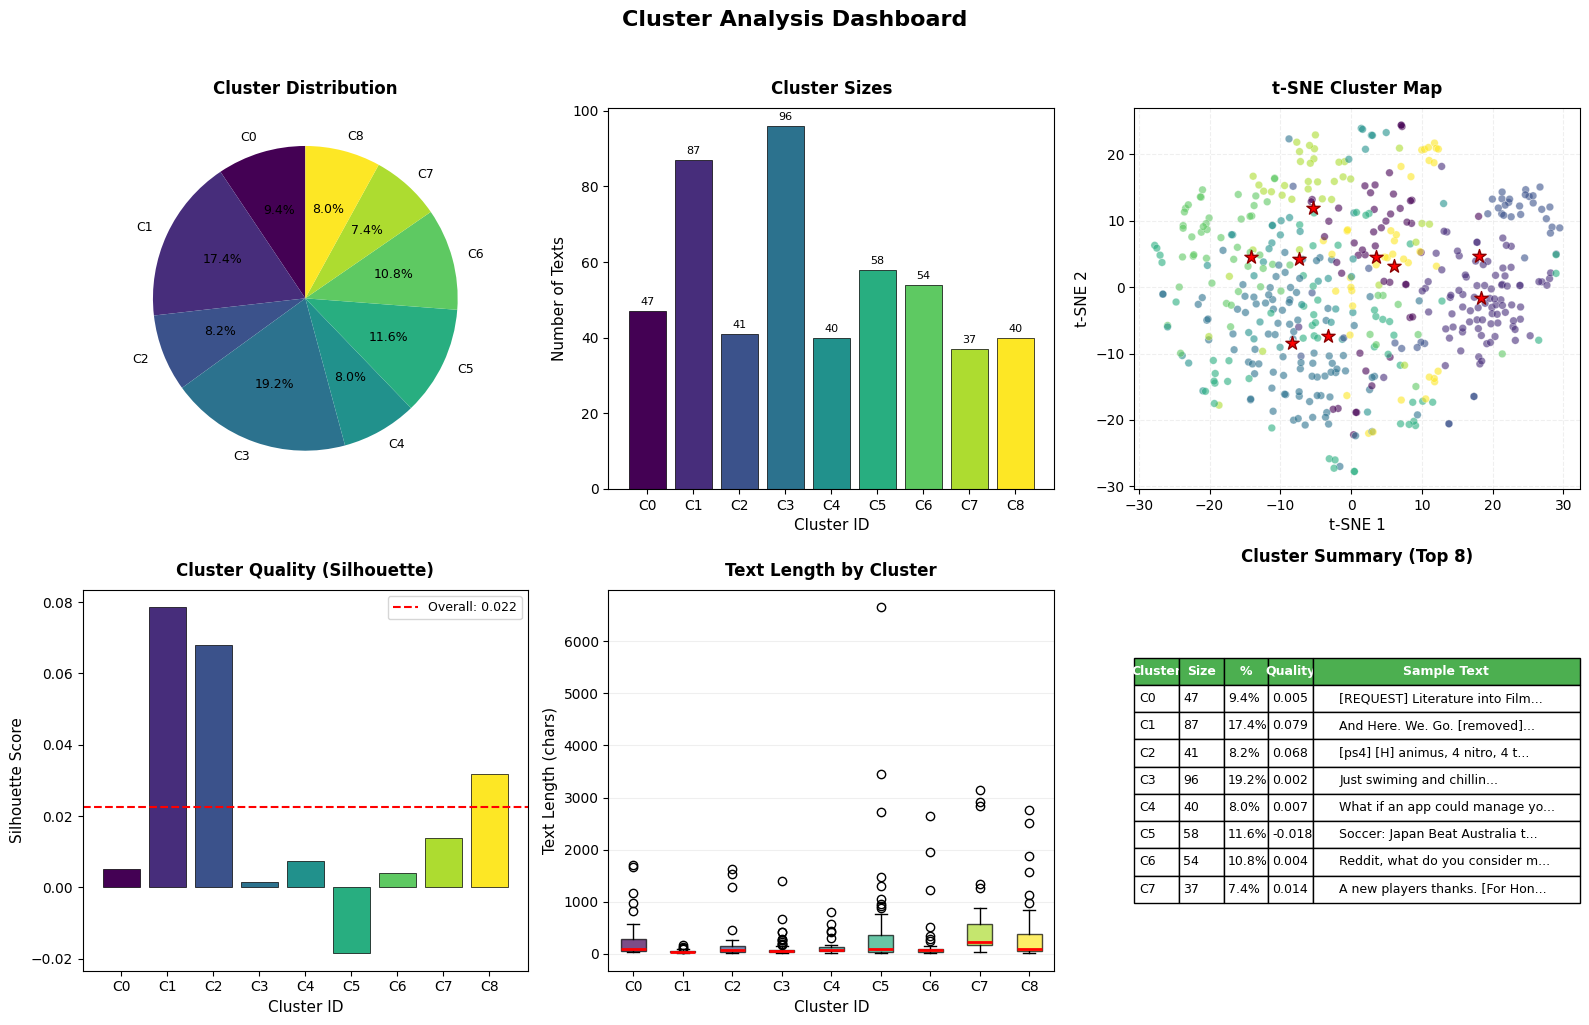

📊 Dashboard Summary:
   • Total texts: 500
   • Number of clusters: 9
   • Avg cluster size: 55.6 texts
   • Overall silhouette: 0.0225


In [43]:
# Create comprehensive cluster analysis visualizations
import matplotlib.pyplot as plt
import numpy as np

# Create subplots for multiple visualizations
fig = plt.figure(figsize=(16, 10))

# 1. Pie chart for cluster distribution
ax1 = plt.subplot(2, 3, 1)
cluster_counts = submissions_df['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
wedges, texts, autotexts = ax1.pie(
    cluster_counts, 
    labels=[f'C{i}' for i in cluster_counts.index],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 9}
)
ax1.set_title('Cluster Distribution', fontsize=12, fontweight='bold', pad=10)

# 2. Bar chart for cluster sizes
ax2 = plt.subplot(2, 3, 2)
bars = ax2.bar(range(optimal_k), cluster_counts, color=colors, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Cluster ID', fontsize=11)
ax2.set_ylabel('Number of Texts', fontsize=11)
ax2.set_title('Cluster Sizes', fontsize=12, fontweight='bold', pad=10)
ax2.set_xticks(range(optimal_k))
ax2.set_xticklabels([f'C{i}' for i in range(optimal_k)])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{int(height)}', ha='center', va='bottom', fontsize=8)

# 3. Clean t-SNE visualization without text overlays
ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(
    submissions_df['tsne_x'], 
    submissions_df['tsne_y'],
    c=submissions_df['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=30,
    edgecolors='white',
    linewidth=0.3
)

# Add cluster centroids
for cluster_id in range(optimal_k):
    cluster_points = submissions_df[submissions_df['cluster'] == cluster_id]
    if len(cluster_points) > 0:
        centroid_x = cluster_points['tsne_x'].mean()
        centroid_y = cluster_points['tsne_y'].mean()
        ax3.scatter(centroid_x, centroid_y, c='red', s=100, marker='*', 
                   edgecolors='darkred', linewidth=1, zorder=5)
        ax3.text(centroid_x, centroid_y, f'{cluster_id}', 
                fontsize=8, ha='center', va='center', color='white', fontweight='bold')

ax3.set_xlabel('t-SNE 1', fontsize=11)
ax3.set_ylabel('t-SNE 2', fontsize=11)
ax3.set_title('t-SNE Cluster Map', fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.2, linestyle='--')

# 4. Silhouette scores by cluster
ax4 = plt.subplot(2, 3, 4)
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(embeddings_scaled, cluster_labels)
cluster_silhouettes = []
for i in range(optimal_k):
    cluster_sil = silhouette_vals[cluster_labels == i].mean()
    cluster_silhouettes.append(cluster_sil)

bars = ax4.bar(range(optimal_k), cluster_silhouettes, color=colors, edgecolor='black', linewidth=0.5)
ax4.axhline(y=np.mean(silhouette_vals), color='red', linestyle='--', 
           label=f'Overall: {np.mean(silhouette_vals):.3f}')
ax4.set_xlabel('Cluster ID', fontsize=11)
ax4.set_ylabel('Silhouette Score', fontsize=11)
ax4.set_title('Cluster Quality (Silhouette)', fontsize=12, fontweight='bold', pad=10)
ax4.set_xticks(range(optimal_k))
ax4.set_xticklabels([f'C{i}' for i in range(optimal_k)])
ax4.legend(fontsize=9)

# 5. Text length distribution by cluster
ax5 = plt.subplot(2, 3, 5)
submissions_df['text_length'] = submissions_df['text'].str.len()
box_data = [submissions_df[submissions_df['cluster'] == i]['text_length'].values 
            for i in range(optimal_k)]
bp = ax5.boxplot(box_data, labels=[f'C{i}' for i in range(optimal_k)], 
                  patch_artist=True, medianprops=dict(color='red', linewidth=2))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax5.set_xlabel('Cluster ID', fontsize=11)
ax5.set_ylabel('Text Length (chars)', fontsize=11)
ax5.set_title('Text Length by Cluster', fontsize=12, fontweight='bold', pad=10)
ax5.grid(True, alpha=0.2, axis='y')

# 6. Cluster summary table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

# Create summary data
summary_data = []
for i in range(min(8, optimal_k)):  # Show top 8 clusters
    cluster_df = submissions_df[submissions_df['cluster'] == i]
    sample_text = cluster_df['text'].iloc[0][:30] + '...' if len(cluster_df) > 0 else 'N/A'
    summary_data.append([
        f'C{i}',
        len(cluster_df),
        f'{len(cluster_df)/len(submissions_df)*100:.1f}%',
        f'{cluster_silhouettes[i]:.3f}',
        sample_text
    ])

table = ax6.table(
    cellText=summary_data,
    colLabels=['Cluster', 'Size', '%', 'Quality', 'Sample Text'],
    cellLoc='left',
    loc='center',
    colWidths=[0.1, 0.1, 0.1, 0.1, 0.6]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Style header
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Cluster Summary (Top 8)', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('Cluster Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"📊 Dashboard Summary:")
print(f"   • Total texts: {len(submissions_df)}")
print(f"   • Number of clusters: {optimal_k}")
print(f"   • Avg cluster size: {len(submissions_df)/optimal_k:.1f} texts")
print(f"   • Overall silhouette: {np.mean(silhouette_vals):.4f}")


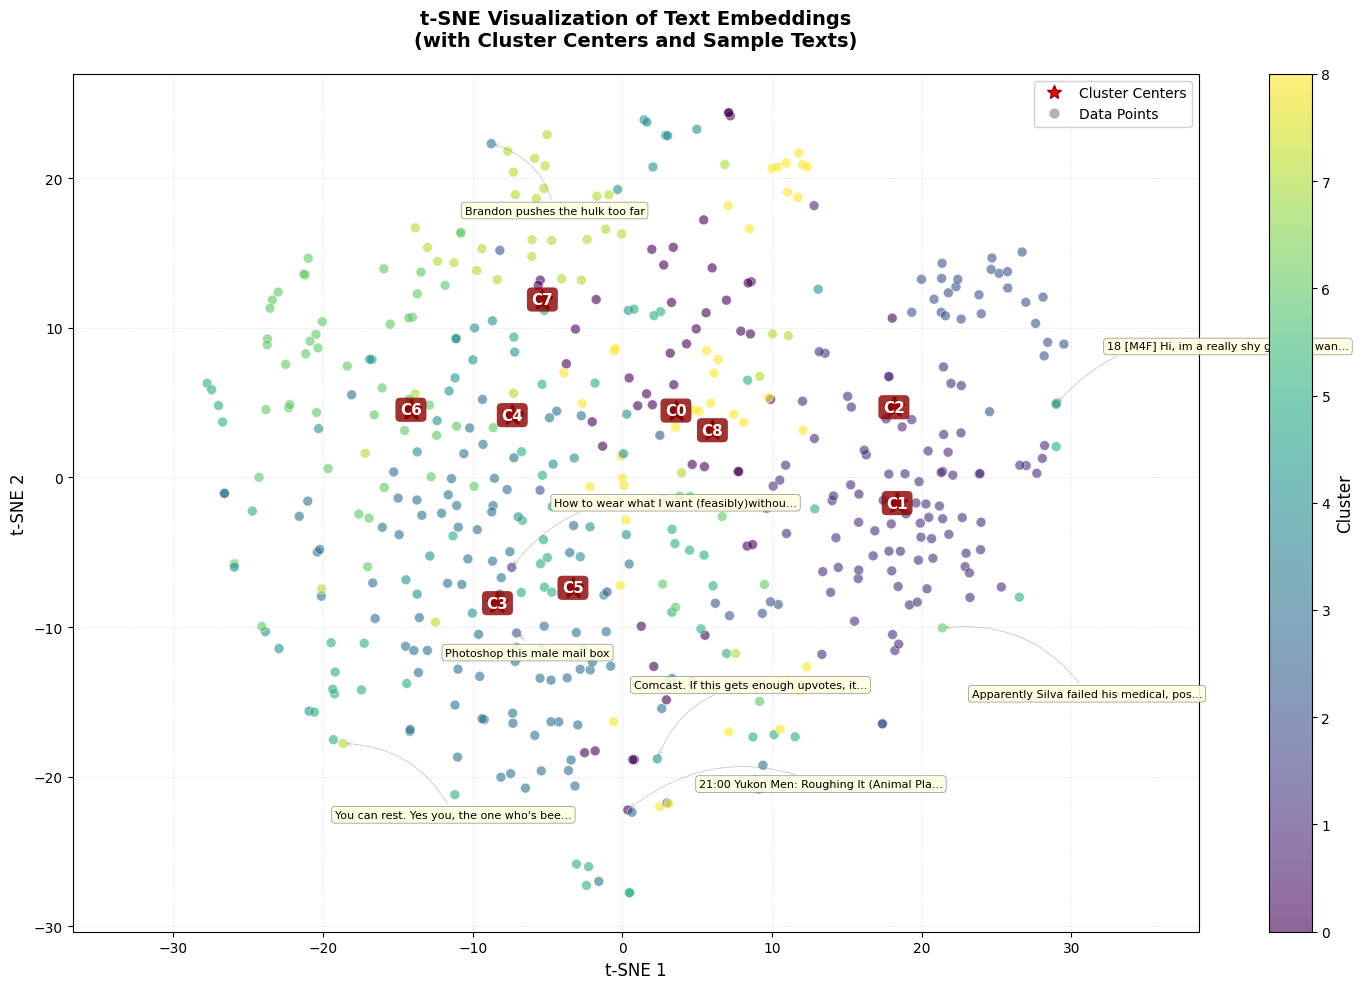

📊 Visualization shows 9 clusters with centroids marked as red stars
💡 Sample texts from distinctive points in each cluster are annotated


In [44]:
# Create improved visualization with text overlays
import matplotlib.pyplot as plt
import numpy as np

# Create figure with better size
fig, ax = plt.subplots(figsize=(15, 10))

# Create scatter plot with cluster colors
scatter = ax.scatter(
    submissions_df['tsne_x'], 
    submissions_df['tsne_y'],
    c=submissions_df['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=50,
    edgecolors='white',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster', fontsize=12)

# Calculate and plot cluster centroids with labels
for cluster_id in range(optimal_k):
    cluster_points = submissions_df[submissions_df['cluster'] == cluster_id]
    if len(cluster_points) > 0:
        # Calculate centroid
        centroid_x = cluster_points['tsne_x'].mean()
        centroid_y = cluster_points['tsne_y'].mean()
        
        # Plot centroid
        ax.scatter(
            centroid_x, centroid_y,
            c='red', s=200, marker='*',
            edgecolors='darkred', linewidth=2,
            zorder=5, alpha=0.9
        )
        
        # Add cluster label with background
        ax.annotate(
            f'C{cluster_id}',
            (centroid_x, centroid_y),
            fontsize=11, fontweight='bold',
            ha='center', va='center',
            color='white',
            bbox=dict(
                boxstyle='round,pad=0.3',
                facecolor='darkred',
                alpha=0.8,
                edgecolor='none'
            ),
            zorder=10
        )

# Add sample text annotations for interesting points
# Select diverse points (one from each cluster if possible)
texts_to_show = []
for cluster_id in range(min(8, optimal_k)):  # Show max 8 text samples
    cluster_df = submissions_df[submissions_df['cluster'] == cluster_id]
    if len(cluster_df) > 0:
        # Get point furthest from centroid (often most distinctive)
        centroid_x = cluster_df['tsne_x'].mean()
        centroid_y = cluster_df['tsne_y'].mean()
        distances = np.sqrt(
            (cluster_df['tsne_x'] - centroid_x)**2 + 
            (cluster_df['tsne_y'] - centroid_y)**2
        )
        idx = cluster_df.iloc[distances.argmax()].name
        texts_to_show.append(idx)

# Add text annotations with arrows
for idx in texts_to_show:
    row = submissions_df.loc[idx]
    text = row['text'][:40] + '...' if len(row['text']) > 40 else row['text']
    
    # Calculate offset for text to avoid overlap
    angle = np.random.uniform(0, 2*np.pi)
    offset_x = 5 * np.cos(angle)
    offset_y = 5 * np.sin(angle)
    
    ax.annotate(
        text,
        xy=(row['tsne_x'], row['tsne_y']),
        xytext=(row['tsne_x'] + offset_x, row['tsne_y'] + offset_y),
        fontsize=8,
        bbox=dict(
            boxstyle='round,pad=0.3',
            facecolor='lightyellow',
            alpha=0.9,
            edgecolor='gray',
            linewidth=0.5
        ),
        arrowprops=dict(
            arrowstyle='->',
            connectionstyle='arc3,rad=0.3',
            color='gray',
            alpha=0.5,
            lw=0.5
        ),
        zorder=6
    )

# Styling
ax.set_xlabel('t-SNE 1', fontsize=12)
ax.set_ylabel('t-SNE 2', fontsize=12)
ax.set_title('t-SNE Visualization of Text Embeddings\n(with Cluster Centers and Sample Texts)', 
             fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Set aspect ratio
ax.set_aspect('equal', adjustable='datalim')

# Add legend for cluster centers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='*', color='w', markerfacecolor='red', 
           markersize=10, label='Cluster Centers', markeredgecolor='darkred'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, alpha=0.6, label='Data Points')
]
ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

print(f"📊 Visualization shows {optimal_k} clusters with centroids marked as red stars")
print(f"💡 Sample texts from distinctive points in each cluster are annotated")


## 5. Semantic Similarity Search


In [46]:
def find_similar_texts(query, model, df, embeddings_scaled, scaler, top_k=5):
    """Find most similar texts to a query
    
    Args:
        query: The search query text
        model: The sentence transformer model
        df: DataFrame containing texts and cluster labels
        embeddings_scaled: Scaled embeddings array
        scaler: StandardScaler fitted to embeddings
        top_k: Number of similar texts to return
    """
    
    # Encode query
    query_embedding = model.encode(query, convert_to_numpy=True)
    
    # Standardize query embedding
    query_scaled = scaler.transform([query_embedding])
    
    # Calculate cosine similarities
    similarities = cosine_similarity(query_scaled, embeddings_scaled)[0]
    
    # Get top-k indices
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        # Use iloc to access DataFrame rows by position
        results.append({
            'text': df.iloc[idx]['text'],
            'similarity': similarities[idx],
            'cluster': df.iloc[idx]['cluster']
        })
    
    return results

# Test semantic search
query = "I can't afford rent in my city anymore"
print(f"🔍 Query: '{query}'")
print("=" * 80)

similar_texts = find_similar_texts(query, model, submissions_df, embeddings_scaled, scaler, top_k=5)

for i, result in enumerate(similar_texts, 1):
    print(f"\n{i}. Similarity: {result['similarity']:.3f} (Cluster {result['cluster']})")
    print(f"   {result['text'][:200]}...")


🔍 Query: 'I can't afford rent in my city anymore'

1. Similarity: 0.269 (Cluster 4)
   no bicycle option? i was looking into getting into postmates as a side gig kind of thing, but it looks like you can only use your bicycle in certain cities. is that correct? i was hoping to use a bike...

2. Similarity: 0.239 (Cluster 4)
   What's your most frustrated "I'm not paying for that/that much" moment?...

3. Similarity: 0.231 (Cluster 4)
   Thanks Pop Shack! (Boulavard Mall, Las Vegas) I've been looking for this one for a while...

4. Similarity: 0.223 (Cluster 4)
   An example of the price gouging in Irving, TX today. It was $2.17 last week...

5. Similarity: 0.221 (Cluster 4)
   In downtown ATL...


## 6. Save Results


In [ ]:
# Save embeddings and clusters
# Prepare dataframe for saving
save_df = submissions_df.copy()

# Save compressed embeddings (float16 for space efficiency)
save_df['embedding_compressed'] = [
    np.array(emb, dtype=np.float16).tobytes() 
    for emb in embeddings
]

# Select columns to save (excluding bytes column for parquet compatibility)
save_df_parquet = save_df[['text', 'cluster', 'tsne_x', 'tsne_y']].copy()

# Try to save as parquet first
parquet_file = DATA_PROCESSED / "sentence_transformer_embeddings.parquet"
try:
    save_df_parquet.to_parquet(parquet_file, compression='snappy', index=False)
    print(f"✅ Saved text data to: {parquet_file}")
except Exception as e:
    print(f"⚠️ Could not save as parquet: {e}")
    # Note: This can happen if kernel needs restart after installing pyarrow

# Save embeddings separately as numpy file (more efficient for arrays)
embeddings_file = DATA_PROCESSED / "sentence_transformer_embeddings.npy"
np.save(embeddings_file, embeddings)
print(f"✅ Saved embeddings to: {embeddings_file}")

# Alternative: Save complete data as pickle (includes everything)
pickle_file = DATA_PROCESSED / "sentence_transformer_complete.pkl"
save_df.to_pickle(pickle_file)
print(f"✅ Saved complete data to: {pickle_file}")

print(f"\n📁 Files created:")
print(f"  - Text & clusters: {parquet_file.name if parquet_file.exists() else 'not saved'}")
print(f"  - Embeddings array: {embeddings_file.name}")
print(f"  - Complete backup: {pickle_file.name}")

# Save metadata
metadata = {
    'model': model_name,
    'embedding_dim': embedding_dim,
    'num_texts': len(embeddings),
    'optimal_k': optimal_k,
    'best_silhouette': max(silhouette_scores),
    'created': datetime.now().isoformat(),
    'clusters': {
        str(i): int(cluster_stats.loc[i, 'count']) 
        for i in range(optimal_k)
    }
}

metadata_file = DATA_PROCESSED / "sentence_transformer_metadata.json"
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved to: {metadata_file}")

print(f"\n📊 Summary:")
print(f"  - Model used: {model_name}")
print(f"  - Texts embedded: {len(embeddings)}")
print(f"  - Embedding dimensions: {embedding_dim}")
print(f"  - Optimal clusters: {optimal_k}")
print(f"  - Best silhouette score: {max(silhouette_scores):.4f}")
print(f"  - File size: ~{save_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


⚠️ Could not save as parquet: A type extension with name pandas.period already defined
✅ Saved embeddings to: /home/ubuntu/dsan6000/dsan6000-final-project/data/processed/sentence_transformer_embeddings.npy
✅ Saved complete data to: /home/ubuntu/dsan6000/dsan6000-final-project/data/processed/sentence_transformer_complete.pkl

📁 Files created:
  - Text & clusters: not saved
  - Embeddings array: sentence_transformer_embeddings.npy
  - Complete backup: sentence_transformer_complete.pkl
✅ Metadata saved to: /home/ubuntu/dsan6000/dsan6000-final-project/data/processed/sentence_transformer_metadata.json

📊 Summary:
  - Model used: all-MiniLM-L6-v2
  - Texts embedded: 500
  - Embedding dimensions: 384
  - Optimal clusters: 14
  - Best silhouette score: 0.0226
  - File size: ~1.6 MB


## Summary

### ✅ What We Accomplished:
1. **Sentence-Transformer Embeddings**: Generated high-quality BERT-based embeddings
2. **K-means Clustering**: Found optimal K using silhouette analysis
3. **t-SNE Visualization**: Created interactive 2D projections
4. **Semantic Search**: Built similarity search functionality
5. **Efficient Storage**: Saved compressed embeddings in parquet format

### 📊 Key Advantages:
- **Free & Local**: No API costs or cloud dependencies
- **Fast**: ~1000 texts/minute on CPU
- **High Quality**: State-of-the-art BERT models
- **Flexible**: Multiple model options available
- **Production Ready**: Efficient storage and retrieval

### 🚀 Next Steps:
1. **Scale Up**: Process full Reddit dataset
2. **Topic Modeling**: Extract themes from each cluster
3. **Temporal Analysis**: Track cluster evolution over time
4. **Fine-tuning**: Try different embedding models
5. **Integration**: Combine with sentiment analysis

### 💡 Model Recommendations:
- **Speed Priority**: Use `all-MiniLM-L6-v2` (current)
- **Quality Priority**: Switch to `all-mpnet-base-v2`
- **Multilingual**: Try `paraphrase-multilingual-mpnet-base-v2`
- **Domain-Specific**: Fine-tune on your data
